In [265]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

In [294]:
data_x = pd.read_csv("./data/practice/acic_practice_0001.csv")
data_y = pd.read_csv("./data/practice_year/acic_practice_year_0001.csv")

# propensity score

In [342]:
data_y.head()

,id.practice,year,Y,Z,post,n.patients,V1_avg,V2_avg,V3_avg,V4_avg,V5_A_avg,V5_B_avg,V5_C_avg
0,1,1,1025.523263,1,0,113,10.808207,2.920354,0.539823,0.279685,0.690265,0.274336,0.035398
1,1,2,1613.777568,1,0,109,10.767909,2.871560,0.532110,0.261003,0.706422,0.266055,0.027523
2,1,3,1189.200788,1,1,121,10.896147,2.867769,0.528926,0.207485,0.727273,0.231405,0.041322
3,1,4,1619.829704,1,1,131,10.549631,2.717557,0.541985,0.183141,0.702290,0.259542,0.038168
4,2,1,834.169421,1,0,264,11.980692,2.946970,0.530303,-0.137824,0.715909,0.159091,0.125000


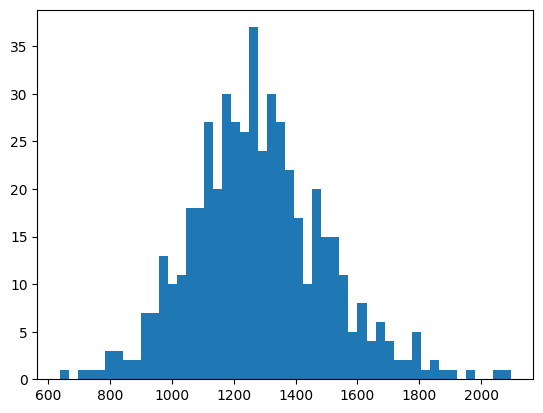

In [353]:
plt.hist(data_y.loc[data_y['year']==4,'Y'], bins=50)
plt.show()

In [295]:
data_z = pd.merge(data_x, data_y[['id.practice','Z']].drop_duplicates(), on='id.practice')
df = data_z
ct = ['X2','X4']
for c in ct:
    df[c] = df[c].astype('category')

debias_m = LGBMClassifier(max_depth=3)

X = ['X1','X2','X3','X4','X5','X6','X7','X8','X9']
T = ['Z']
#ps_res =  df[T] - cross_val_predict(debias_m, df[X], df[T].values.ravel(), cv=5, method='predict_proba')[:,1].reshape(-1,1) + df[T].mean()

(500, 11)

In [318]:
debias_m = LGBMClassifier(objective = 'binary',
                         is_unbalance = True,
                         #metric = 'log_loss',
                         metric = 'binary_logloss,auc',
                         max_depth = 6,
                         num_leaves = 20,
                         learning_rate = 0.1,
                         #feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         #bagging = 1,
                         #subsample_freq = 2,
                         reg_alpha = 0.002,
                         reg_lambda = 10,
                         cat_smooth = 0,
                         n_estimators = 200,   
                        )

ps = cross_val_predict(debias_m, data_z[X], data_z[T].values.ravel(), cv=10, method='predict_proba')[:,1]
#ps_res =  df[T] - cross_val_predict(debias_m, df[X], df[T].values.ravel(), cv=5, method='predict_proba')[:,1].reshape(-1,1) + df[T].mean()
data_x = data_x.assign(ps = ps)

In [319]:
data_z = data_z.assign(ps = ps)
data_z

,id.practice,X1,X2,X3,X4,X5,X6,X7,X8,X9,Z,ps
0,1,0,A,1,A,1,20.774076,14.153255,0.161126,43.431874,1,0.765634
1,2,0,A,0,C,0,33.565928,3.284657,0.556784,12.721988,1,0.838888
2,3,0,C,1,A,1,57.283021,11.178051,0.257244,-7.352617,0,0.011570
3,4,1,C,1,A,0,41.900776,1.542463,0.129618,20.032199,0,0.048352
4,5,1,B,1,A,0,41.486809,7.504068,0.413924,35.449536,0,0.016355
...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0,C,1,A,1,29.898841,17.945129,0.381701,40.224974,1,0.885632
496,497,1,C,0,A,1,20.378333,20.770890,0.422255,62.857150,0,0.914869
497,498,0,A,0,A,0,30.162733,9.174455,0.205427,-4.931348,0,0.168042
498,499,1,C,0,A,1,32.795499,19.769398,0.295538,84.228736,1,0.942508


# average outcome for year 3,4

In [298]:
data_o = pd.merge(data_x, data_y, on='id.practice')
df = data_o
ct = ['X2','X4']
for c in ct:
    df[c] = df[c].astype('category')
    
#XV = df.columns.drop(['id.practice','year','post','Z','n.patients'])
V = ['V1_avg', 'V2_avg', 'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg']
XV = V + X
Y = ['Y']

In [299]:
means = []
for i in range(1,5):
    means.append(np.average(df[(df['year'] == i) & (df['Z'] == 0)]['Y'], weights = df[(df['year'] == i) & (df['Z'] == 0)]['n.patients']))
    #means.append(df[(df['year']==i) & (df['Z']==0)]['Y'].mean())
    print(means[i-1])

avgs = pd.DataFrame({'year': [1, 2, 3, 4], 'ft': means})
df = pd.merge(df, avgs, on='year')

df_34 = df[df['year'] >= 3]

865.3614330552035
1006.572361414004
1127.312134618135
1247.3123710094226


In [300]:
for i in [3,4]:
    print(np.average(df[(df['year'] == i) & (df['Z'] == 1)]['Y'], weights = df[(df['year'] == i) & (df['Z'] == 1)]['n.patients']))
    #print(df[(df['year']==i) & (df['Z']==1)]['Y'].mean())

1213.996301442881
1339.7549908514943


In [88]:
df_34.columns

Index(['id.practice', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'ps', 'year', 'Y', 'Z', 'post', 'n.patients', 'V1_avg', 'V2_avg',
       'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg', 'ft'],
      dtype='object')

In [330]:
denoise_m = LGBMRegressor(is_unbalance = True,
                         #metric = 'log_loss',
                         metric = 'mean_squared_error',
                         max_depth = -1,
                         num_leaves = 20,
                         learning_rate = 0.1,
                         #feature_fraction = 0.7,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         #bagging = 1,
                         #subsample_freq = 2,
                         reg_alpha = 0.002,
                         reg_lambda = 10,
                         cat_smooth = 0,
                         n_estimators = 200,   
                        )

# \hat{\mu_0(v)+e(x)r(x)+f(t)}
#pred3 = cross_val_predict(denoise_m, df_3[V], df_3[Y].values.ravel(), cv=10, method='predict_proba')[:,1]
#pred4 = cross_val_predict(denoise_m, df_4[V], df_4[Y].values.ravel(), cv=10, method='predict_proba')[:,1]

df_34 = df[df['year'] >= 3]
pred_M = cross_val_predict(denoise_m, df_34[V], df_34['Y']-df_34['ft'], fit_params={'sample_weight':df_34['n.patients']}, cv=10)

# WLS for ATTs

In [332]:
df_34 = df_34.assign(y_res = df_34['Y'] - pred_M - df_34['ft'], z_res = df_34['Z'] - df_34['ps'])
df_34.columns

Index(['id.practice', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'ps', 'year', 'Y', 'Z', 'post', 'n.patients', 'V1_avg', 'V2_avg',
       'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg', 'ft', 'y_res',
       'z_res'],
      dtype='object')

In [359]:
# standardization, estimate CATE by regression

scaler = StandardScaler()

df_34 = pd.get_dummies(df_34, columns=['X2','X4'])
df_34[['X6','X7','X8','X9']] = scaler.fit_transform(df_34[['X6','X7','X8','X9']]) / 2

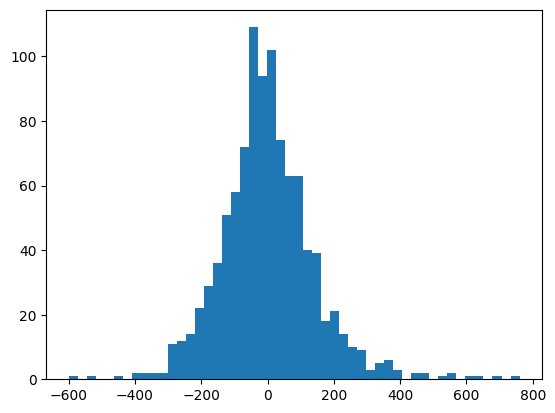

In [333]:
plt.hist(df_34['y_res'], bins=50)
plt.show()

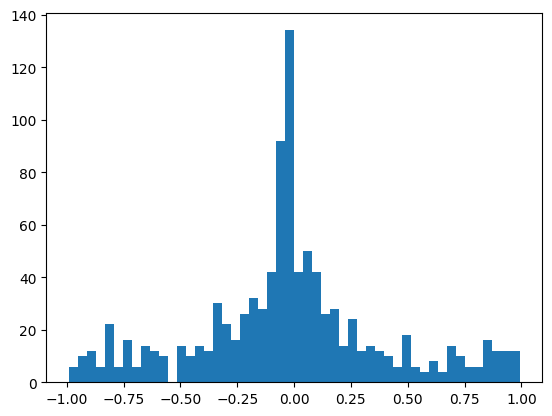

In [329]:
plt.hist(df_34['z_res'], bins=50)
plt.show()

In [367]:
df_3 = df_34[df_34['year'] == 3]
df_4 = df_34[df_34['year'] == 4]

In [92]:
model_34 = smf.wls(formula='y_res ~ z_res', data=df_34, weights=df_34['n.patients']).fit()

In [360]:
df_34.columns

Index(['id.practice', 'X1', 'X3', 'X5', 'X6', 'X7', 'X8', 'X9', 'ps', 'year',
       'Y', 'Z', 'post', 'n.patients', 'V1_avg', 'V2_avg', 'V3_avg', 'V4_avg',
       'V5_A_avg', 'V5_B_avg', 'V5_C_avg', 'ft', 'y_res', 'z_res', 'X2_A',
       'X2_B', 'X2_C', 'X4_A', 'X4_B', 'X4_C'],
      dtype='object')

In [372]:
formula = 'y_res ~ z_res * ('
for name in ['X1', 'X3', 'X5', 'X6', 'X7', 'X8', 'X9', 'X2_A', 'X2_B', 'X4_A']: # to avoid colinearlity
    formula += name + ' + '
formula += 'X4_B)'
formula

'y_res ~ z_res * (X1 + X3 + X5 + X6 + X7 + X8 + X9 + X2_A + X2_B + X4_A + X4_B)'

In [373]:
model_3 = smf.wls(formula=formula, data=df_3, weights=df_3['n.patients']).fit()
model_4 = smf.wls(formula=formula, data=df_4, weights=df_4['n.patients']).fit()

In [374]:
df_3.columns

Index(['id.practice', 'X1', 'X3', 'X5', 'X6', 'X7', 'X8', 'X9', 'ps', 'year',
       'Y', 'Z', 'post', 'n.patients', 'V1_avg', 'V2_avg', 'V3_avg', 'V4_avg',
       'V5_A_avg', 'V5_B_avg', 'V5_C_avg', 'ft', 'y_res', 'z_res', 'X2_A',
       'X2_B', 'X2_C', 'X4_A', 'X4_B', 'X4_C'],
      dtype='object')

In [387]:
df_3 = df_3.assign(cate=model_3.predict(df_3.assign(z_res=1)) - model_3.predict(df_3.assign(z_res=0)))
df_4 = df_4.assign(cate=model_4.predict(df_4.assign(z_res=1)) - model_4.predict(df_4.assign(z_res=0)))

In [393]:
np.average(df_3['cate'], weights=df_3['n.patients'])

54.66394462872983

In [87]:
model = LinearRegression()
r3 = model.fit(X=df_3[['z_res']], y=df_3[['y_res']], sample_weight=df_3['n.patients'])
#r4 = model.fit(X=df_4[['z_res']], y=df_4[['y_res']], sample_weight=df_4['n.patients'])

In [335]:
r3 = model_3.params.z_res
r4 = model_4.params.z_res
r = [r3,r4]
r

[15.924817748741317, 17.7724544380259]

# Iterative Estimation

In [ ]:
# initial estimator f; cross-fitting w, M; estimating r3, r4 by regression

# repeat:
#   subtracting w*r; estimating f; cross-fitting m
#   evaluating M = m + f;
#   estimating r3,r4
# until convergence

In [220]:
df = df.assign(y_cor = df['Y'])

In [63]:
d_t = df

In [69]:
df=d_t

In [131]:
for i in [3,4]:
    df.loc[df['year']==i,'y_cor'] -= df[df['year'] == i]['Z'] * r[i-3]
    df.loc[df['year']==i,'ft'] = df[df['year'] == i]['y_cor'].mean()
    df_34.loc[df_34['year']==i,'ft'] = df[df['year'] == i]['y_cor'].mean()

In [132]:
mu_0 = LGBMRegressor(is_unbalance = True,
                     #metric = 'log_loss',
                     metric = 'mean_squared_error',
                     max_depth = 4,
                     num_leaves = 20,
                     learning_rate = 0.1,
                     #feature_fraction = 0.7,
                     min_child_samples=21,
                     min_child_weight=0.001,
                     #bagging = 1,
                     #subsample_freq = 2,
                     reg_alpha = 0.002,
                     reg_lambda = 10,
                     cat_smooth = 0,
                     n_estimators = 200,   
                     )

cross_val_predict(mu_0, df[V], df['Y']-df['ft'])

array([306.0367264 ,  12.21831348, 285.80749828, ..., -46.8342468 ,
        14.48820984, -66.45481579])

In [133]:
mu_0 = LGBMRegressor(is_unbalance = True,
                     #metric = 'log_loss',
                     metric = 'mean_squared_error',
                     max_depth = 4,
                     num_leaves = 20,
                     learning_rate = 0.1,
                     #feature_fraction = 0.7,
                     min_child_samples=21,
                     min_child_weight=0.001,
                     #bagging = 1,
                     #subsample_freq = 2,
                     reg_alpha = 0.002,
                     reg_lambda = 10,
                     cat_smooth = 0,
                     n_estimators = 200,   
                     )

df = df.assign(mu = cross_val_predict(mu_0, df[V], df['Y']-df['ft']))

In [107]:
df.columns

Index(['id.practice', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'ps', 'year', 'Y', 'Z', 'post', 'n.patients', 'V1_avg', 'V2_avg',
       'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg', 'ft', 'y_cor',
       'mu', 'y_res'],
      dtype='object')

In [108]:
df_34.columns

Index(['id.practice', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       'ps', 'year', 'Y', 'Z', 'post', 'n.patients', 'V1_avg', 'V2_avg',
       'V3_avg', 'V4_avg', 'V5_A_avg', 'V5_B_avg', 'V5_C_avg', 'ft', 'y_res',
       'z_res'],
      dtype='object')

In [134]:
for i in [3,4]:
    df_34.loc[df_34['year']==i,'y_res'] = df[df['year'] == i]['mu'] + df[df['year'] == i]['ps'] * r[i-3]

In [135]:
df_3 = df_34[df_34['year'] == 3]
df_4 = df_34[df_34['year'] == 4]
model_3 = smf.wls(formula='y_res ~ z_res', data=df_3, weights=df_3['n.patients']).fit()
model_4 = smf.wls(formula='y_res ~ z_res', data=df_4, weights=df_4['n.patients']).fit()

In [185]:
r

[32.865483309799856, 47.58266088874949]

In [136]:
r3 = model_3.params.z_res
r4 = model_4.params.z_res
r = [r3,r4]
r

[33.68970602599228, 25.942007356511574]

In [169]:
df['ft'].unique()

array([ 870.64513368, 1010.07608408, 1153.17218653, 1260.84948403])

In [186]:
np.average(df[df['year'] == i]['y_cor'], weights = df[df['year'] == i]['n.patients'])

1266.136732128633

In [286]:
model_final = LGBMRegressor(max_depth=4)
#model_final = MLPClassifier(hidden_layer_sizes=(50,), solver='lbfgs',alpha=0.1, random_state=1, max_iter=10000, learning_rate='invscaling', early_stopping=True)
 
# create the weights
w = df_34['z_res'] ** 2 
 
# create the transformed target
y_star = (df_34['y_res'] / df_34['z_res'])
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=df_34[V], y=y_star, sample_weight=w)
#model_final.fit(X=df_34[V], y=y_star)

LGBMRegressor(max_depth=4)

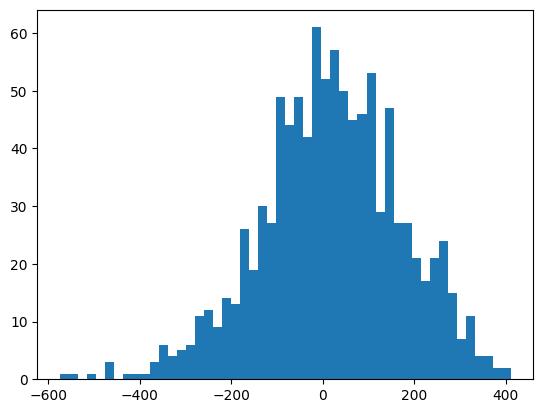

In [341]:
plt.hist(df[df['year']<=2]['mu'], bins=50)
plt.show()

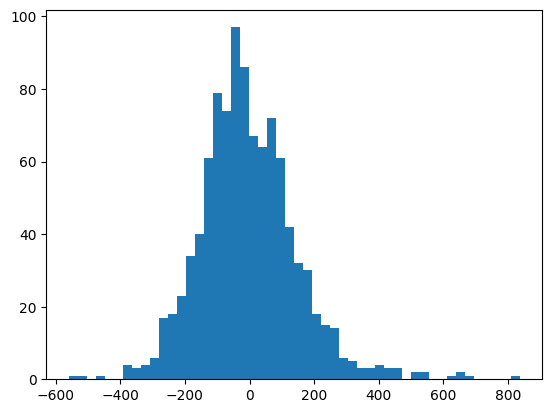

In [340]:
plt.hist(df_34['y_res'], bins=50)
plt.show()

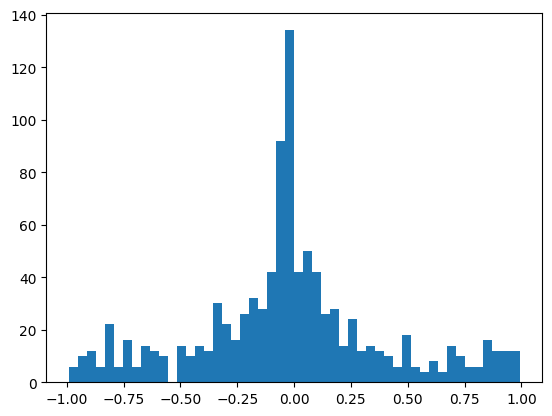

In [338]:
plt.hist(df_34['z_res'], bins=50)
plt.show()

In [339]:
max_iter = 50
it = 1

while it < max_iter:
    df = df.assign(y_cor = df['Y'])
    
    for i in [3,4]:
        df.loc[df['year']==i,'y_cor'] -= df[df['year'] == i]['Z'] * r[i-3]
        df.loc[df['year']==i,'ft'] = np.average(df[df['year'] == i]['y_cor'], weights = df[df['year'] == i]['n.patients'])
        df_34.loc[df_34['year']==i,'ft'] = np.average(df[df['year'] == i]['y_cor'], weights = df[df['year'] == i]['n.patients'])
    
    mu_0 = LGBMRegressor(is_unbalance = True,
                     metric = 'mean_squared_error',
                     max_depth = -1,
                     num_leaves = 20,
                     learning_rate = 0.1,
                     #feature_fraction = 0.7,
                     min_child_samples=21,
                     min_child_weight=0.001,
                     #bagging = 1,
                     #subsample_freq = 2,
                     reg_alpha = 0.002,
                     reg_lambda = 10,
                     cat_smooth = 0,
                     n_estimators = 200,   
                     )

    df = df.assign(mu = cross_val_predict(mu_0, df[V], df['y_cor']-df['ft'], fit_params={'sample_weight':df['n.patients']}))
    
    for i in [3,4]:
        df_34.loc[df_34['year']==i,'y_res'] = it/(it+1) * df_34.loc[df_34['year']==i,'y_res'] + \
                                              (df[df['year'] == i]['Y'] - df[df['year'] == i]['mu'] - \
                                              df[df['year'] == i]['ps'] * r[i-3] - df[df['year'] == i]['ft']) / (it+1)
        
    df_3 = df_34[df_34['year'] == 3]
    df_4 = df_34[df_34['year'] == 4]
    model_3 = smf.wls(formula='y_res ~ z_res', data=df_3, weights=df_3['n.patients']).fit()
    model_4 = smf.wls(formula='y_res ~ z_res', data=df_4, weights=df_4['n.patients']).fit()
    
    r3 = model_3.params.z_res
    r4 = model_4.params.z_res
    r_old = r[:]
    r = [r3, r4]
    err = [abs(r[0]-r_old[0]), abs(r[1]-r_old[1])]
    print(r)
    
    if max(err) < 0.01:
        break
    
    it += 1
    
print(r, it)

[35.55304125740407, 49.24918673867093]
[36.172269414929914, 51.16826996686993]
[37.05939155152342, 51.306931381127676]
[37.46854542256627, 51.81950944143455]
[37.809391936664724, 52.30368223005564]
[38.1805743974867, 52.983377953636605]
[38.361137973945816, 53.415201792735935]
[38.416754283984744, 53.82098574259241]
[38.95619697945814, 54.26800114781676]
[38.98433829820455, 54.521246644292646]
[39.39475834117958, 54.56369365695974]
[39.811458644222476, 54.734120797658704]
[39.99370334884708, 54.82148686130973]
[40.240539016651, 54.967893715257304]
[40.2322810533595, 55.089435239813724]
[40.27996708702045, 55.29462998083146]
[40.38540789038692, 55.42857931337405]
[40.526435952316035, 55.630946764882616]
[40.756556011046165, 55.60675766776307]
[40.86168603228269, 55.717391427806305]
[40.93528805351458, 55.76047463744633]
[41.02700716108808, 55.80770415132742]
[41.04441133635396, 55.85802264986449]
[41.12072983419439, 55.84185025244622]
[41.20376217884943, 55.848434415791964]
[41.22570357

In [150]:
print([2,3],4)

[2, 3] 4


In [147]:
a = [2,3]
b = a[:]
a[0]=4
b

[2, 3]